# Neural Network

In the logistic regression, we transform the data $x$ by a linear transformation $x^T\beta$ and determine the class label by a non-linear sigmoid function. When $x$ are not good features, however, we can construct new features $z$ from $x$ through some non-linear transformation. And the class label can be inferred based on the transformed features.

* $y_i \sim \textrm{Ber}(p_i)$ 
* $p_i = \textrm{sigmoid}(z_i^T\beta)$

Now the question becomes, how to find the transformed features $z_i$. This can be problem-dependent and usually requires domain knowledge in real-world applications.
Here, for simplicity, we assume $z_i$ is constructed by a logistic regression on $x_i$.

* $z_{ik} = \textrm{sigmoid}(x_i^T \alpha_k)$.

Now, we obtained a very simple two-layer neural network.

Let's implement the sigmoid function first for later use.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1.0 - y)

## Loss Function

Since the top-most layer is still a logistic regression, we can define the loss function as the negative log likelihood. Our objective is to minimize this loss.

$$\ell  = - \frac{1}{n}\sum_{i=1}^{n}( y_i \log p_i + (1-y_i) \log (1-p_i) ) $$

In [2]:
def loss_neg_likelihood(p, y):
    """
    Average negative log likelihood as loss function.

    Args:
        p: predicted probability of shape (n, 1).
        y: true values of shape (n, 1).

    Returns:
        L: the loss. It is a scalar.
        dp: the derivative of loss to predictions p of shape (n, 1)
    """
    loss = -np.sum( y*np.log(p) + (1-y)*np.log(1-p) ) / p.shape[0]
    dy = (1 - y)/(1 - p) - (y / p)
    dy = dy / y.shape[0]
    return loss, dy

Alternatively, we can also use the least squares error.

$$\ell = \sum_{i=1}^{n} (y_i - p_i)^2$$

In [3]:
def loss_l2(p, y):
    """
    Use L2-norm (least squares error) as loss function.

    Args:
        p: predicted probability of shape (n, 1).
        y: true values of shape (n, 1).

    Returns:
        L: the loss. It is a scalar.
        dp: the derivative of loss to predictions p of shape (n, 1)
    """
    loss = np.sum(np.square(y - p))
    dp = -(y - p)
    return loss, dp

Note that in the implementation, we returned two values: loss and derivative.
Essentially we will only use the derivative to calculate gradient when apply gradient descent to minimize the loss.
But usually we want to keep tracking the loss to determine when to terminate the optimization.

## Feedforward

To get the final output from the network, we need to transform the data input data $x$ through the layers in the network. This is called _feedforward_. The parameters in each layer is called _weights_ and _bias_.

In our two-layer network case, the operation in each layer is simply a linear transformation followed by a sigmoid function. In the implementation, we abstract this to become a `feed_forward(X, W, b)` function which can be used by both layers, where `X` is the input data to this layer, `W` and `b` are the weights and bias, respectively. The return value of this function is the layer's output.

In [4]:
def feed_forward(X, W, b):
    """
    Feed forward a logistic regression layer.

    Args:
        X: Input data of shape (n, p).
            n = # of data examples.
            p = # of predictors.
        W: Weight matrix in this layer of shape (p, d)
            p = # of predictors.
            d = # of nodes in the next layer.
        b: bias terms of shape (d, )

    Returns:
        y = sigmoid(XW + b.T)  of shape (n, d)
    """
    p = sigmoid(X.dot(W) + b)
    params = (X, W, b, p)
    return p, params

## Backpropagation
In our network, the parameters we want to update are $\beta$ and $\alpha_k$'s.

Suppose the top layer loss function is $\ell$, we want to calculate the following two derivatives:

* $\dfrac{\partial \ell}{\partial \beta}$,
* $\dfrac{\partial \ell}{\partial \alpha} = \dfrac{\partial \ell}{\partial z} \dfrac{\partial z}{\partial \alpha}$.

Note that when calculate the gradient of parameters in the lower layer,
we are actually using the chain rule where the loss is propagated back from upper layers. 
Hence, this is called _backpropagation_.


Then we use these gradient to update the parameters.

* $\beta_{t+1} = \beta_t + \dfrac{\partial \ell}{\partial \beta}$,
* $\alpha_{k,t+1} = \alpha_{k,t} + \dfrac{\partial \ell}{\partial \alpha}$.

In the implementation, we want to abstract the operations.
Suppose $X$ and $y$ are input and output of one layer, $W$ and $b$ are weights and bias in this layer, respectively, the backpropagation operation of the layer simply computes three values:

* $\dfrac{dy}{dW}$ and $\dfrac{dy}{db}$ are the derivative to the parameters in this layer.
* $\dfrac{dy}{dX}$ is the derivative to the input of this layer, which will be propagated back to lower layers.

In [5]:
def back_prop(dy, params):
    """
    Back propagation of a logistic regression layer.

    Args:
        dy: Derivatives output of this layer of shape (n, d)
        params: A tuple of parameters at the current layer.
                In logistic regression layer, we have (X, W, b, p).

    Returns:
        dX: Derivatives to the input for BP to previous layers.
            Same shape of X: (n, p)

        dW: Derivatives to weights W at this layer.
            Same shape of W: (p, d)

        db: Derivatives to bias b at this layer.
            Same shape of b: (d, )
    """
    # Unpack params
    X, W, b, p = params

    dactivate = dsigmoid(p)

    dW = X.T.dot(dy * dactivate)
    db = np.sum(dy * dactivate, axis=0)
    dX = (dy * dactivate).dot(W.T)

    return dX, dW, db

## Training

In the training phase, we apply gradient descent which iteratively update the parameters in the network.
Conceptually, each iteration consists of three operations:

* feed forward to get current network output
* backpropagation to get gradients
* update the paramters along the gradients

Here we also implement a `accuracy()` function to calculate the classification accuracy of our network.

In [6]:
def accuracy(p, y):
    """
    Calculate the accuracy of predictions against truth labels.

        Accuracy = # of correct predictions / # of data.

    Args:
        p: predictions of shape (n, 1)
        y: true labels of shape (n, 1)

    Returns:
        accuracy: The ratio of correct predictions to the size of data.
    """
    return np.mean((p > 0.5) == (y == 1))

def train(X, y, num_hidden=100, num_classes=1, num_iterations=2000,
            loss_function=loss_l2,
            learning_rate=1e-2):
    """
    Make prediction on X using model by doing forward feeding.

    Args:
        X: The data matrix of shape (n, p)
        y: The label for data of shape (n, p)
        num_hidden: number of neurons in the hidden layer.
        num_classes: 1 as we are doing binary classification.
        num_iterations: number of iterations to do training.
        loss_function: what loss function to use.
        learning_rate: learning rate for updating parameters.

    Returns:
        model: tuple of trained parameters (W1, b1, W2, b2).
        all_loss: a list of losses after each iteration.
        accuracies: a list of training accuracies after each iteration.

    """
    n, p = X.shape

    # Initialize parameters.
    # Weights and bias two layers, random numbers centered at 0.
    W1 = 2*np.random.randn(p, num_hidden) - 1
    b1 = 2*np.random.randn(num_hidden, ) - 1
    W2 = 2*np.random.randn(num_hidden, num_classes) - 1
    b2 = 2*np.random.randn(num_classes, ) - 1

    all_loss = []
    accuracies = []

    for it in xrange(num_iterations):
        # Feed forward.
        Z, params1 = feed_forward(X, W1, b1)
        y_out, params2 = feed_forward(Z, W2, b2)

        # Calculate the loss.
        loss, dy = loss_function(y_out, y)

        # Back propagation.
        dZ, dW2, db2 = back_prop(dy, params2)
        dX, dW1, db1 = back_prop(dZ, params1)

        # Update parameters along the gradients.
        W1 -= (learning_rate * dW1)
        b1 -= (learning_rate * db1)
        W2 -= (learning_rate * dW2)
        b2 -= (learning_rate * db2)

        # Save loss and accuracy for plotting the curves.
        all_loss.append(loss)
        accuracies.append(accuracy(y_out, y))

        # Print progress every 100 iterations.
        if it % 100 == 0:
            print 'After iteration %d, loss = %f, accuracy = %f' % (
                it, loss, accuracies[-1])

    # Print the training accuracy at the very last.
    print 'Accuracy on training data: %f' % accuracies[-1]

    # Pack the trained parameters and return it.
    model = (W1, b1, W2, b2)
    return model, all_loss, accuracies

## Testing

Testing is simply to feed forward the entire network using the testing data 
and retrieve the network output.

In [7]:
def test(X, model):
    """
    Make prediction on X using model by doing forward feeding.

    Args:
        X: The data matrix of shape (n, p)
        model: tuple of trained parameters (W1, b1, W2, b2).

    Returns:
        y_predict: The prediction of shape (n, 1).

    """
    W1, b1, W2, b2 = model
    Z, _ = feed_forward(X, W1, b1)
    y_predict, _ = feed_forward(Z, W2, b2)
    return y_predict

## Toy example with hand-written digits

Here we use the digits dataset from scikit-learn to train and test our two-layer neural network.

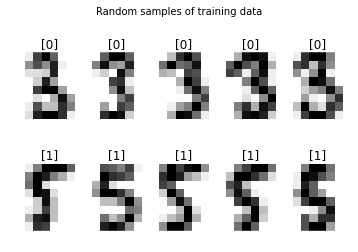

In [8]:
# load data
def load_digits(subset=None, normalize=True):
    """
    Load digits and labels from digits.csv.

    Args:
        subset: A subset of digit from 0 to 9 to return.
                If not specified, all digits will be returned.
        normalize: Whether to normalize data values to between 0 and 1.

    Returns:
        digits: Digits data matrix of the subset specified.
                The shape is (n, p), where
                    n is the number of examples,
                    p is the dimension of features.
        labels: Labels of the digits in an (n, ) array.
                Each of label[i] is the label for data[i, :]
    """
    # load digits.csv, adopted from sklearn.
    import pandas as pd
    df = pd.read_csv('digits.csv')

    # only keep the numbers we want.
    if subset is not None:
        df = df[df.iloc[:,-1].isin(subset)]

    # convert to numpy arrays.
    digits = df.iloc[:,:-1].values.astype('float')
    labels = df.iloc[:,-1].values.astype('int')

    # Normalize digit values to 0 and 1.
    if normalize:
        digits -= digits.min()
        digits /= digits.max()

    # Change the labels to 0 and 1.
    for i in xrange(len(subset)):
        labels[labels == subset[i]] = i

    labels = labels.reshape((labels.shape[0], 1))
    return digits, labels


def display_samples(digits, labels, n_samples=5):
    """
    Display random samples from the training set for each label.
    """
    distinct_label = np.unique(labels[:,0])

    fig_rows = len(distinct_label)
    fig_cols = n_samples
    fig_num = 1

    fig = plt.figure(1)
    fig.suptitle('Random samples of training data')
    for label in distinct_label:
        # random choose samples to display
        choice = np.random.choice(np.ix_(labels[:,0] == label)[0], n_samples)
        for idx in choice:
            ax = fig.add_subplot(fig_rows, fig_cols, fig_num)
            fig.subplots_adjust(wspace=0, hspace=0)
            ax.set_title(labels[idx])
            ax.imshow(digits[idx].reshape(8,8), cmap=plt.cm.gray_r, interpolation='none')
            ax.axis('off')
            fig_num += 1
    plt.show()

# Load digits and labels.
digits, labels = load_digits(subset=[3, 5], normalize=True)

# Uncomment the following line to visualize samples from data.
display_samples(digits, labels)



In practice, we usually split the dataset into a training set and a testing test
and only train the model using the training set.
The model's performance on testing set gives us a general idea on how good our model can do in new data.

In [9]:
def split_samples(digits, labels):
    """Split the data into a training set (70%) and a testing set (30%)."""
    num_samples = digits.shape[0]
    num_training = int(round(num_samples * 0.7))
    indices = np.random.permutation(num_samples)
    training_idx, testing_idx = indices[:num_training], indices[num_training:]
    return (digits[training_idx], labels[training_idx],
            digits[testing_idx], labels[testing_idx])


training_digits, training_labels, testing_digits, testing_labels = split_samples(digits, labels)
print '# training', training_digits.shape[0]
print '# testing', testing_digits.shape[0]

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits, labels, test_size=0.3, random_state=1)

# Train a net and display training accuracy.
model, all_loss, all_accuracies = train(X_train, y_train, loss_function=loss_l2)

# Evaluate on the testing set.
y_predict = test(X_test, model)
testing_accuracy = accuracy(y_predict, y_test)
print 'Accuracy on testing data: %f' % testing_accuracy



# training 255
# testing 110
After iteration 0, loss = 114.028019, accuracy = 0.494118
After iteration 100, loss = 20.677604, accuracy = 0.894118
After iteration 200, loss = 6.524035, accuracy = 0.984314
After iteration 300, loss = 3.366022, accuracy = 0.996078
After iteration 400, loss = 2.295989, accuracy = 0.996078
After iteration 500, loss = 1.754197, accuracy = 0.996078
After iteration 600, loss = 1.432228, accuracy = 0.996078
After iteration 700, loss = 1.218119, accuracy = 0.996078
After iteration 800, loss = 1.062658, accuracy = 0.996078
After iteration 900, loss = 0.942025, accuracy = 0.996078
After iteration 1000, loss = 0.843852, accuracy = 0.996078
After iteration 1100, loss = 0.761368, accuracy = 0.996078
After iteration 1200, loss = 0.690674, accuracy = 0.996078
After iteration 1300, loss = 0.629375, accuracy = 0.996078
After iteration 1400, loss = 0.575861, accuracy = 0.996078
After iteration 1500, loss = 0.528940, accuracy = 1.000000
After iteration 1600, loss = 0.48765

The following code segment plots the loss and training accuracy in the training.

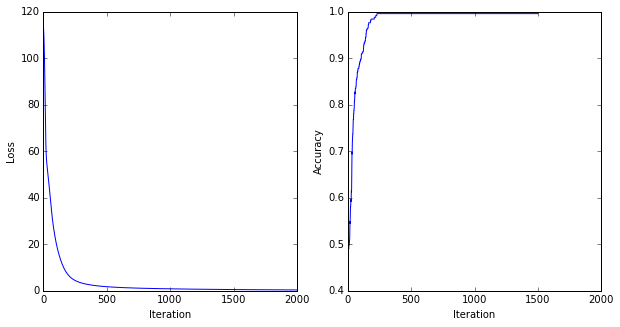

In [10]:
# Plot the curves.
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(range(len(all_loss)), all_loss)
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.plot(range(len(all_accuracies)), all_accuracies)
plt.show()